# Overview
A quick demo notebook made from the [demo.py](https://github.com/sjvasquez/handwriting-synthesis/blob/b2f344063c89eab6439d6313ed20c326234f792d/demo.py) in the original repository. A few niceties were added to make the results show up well in the notebook

In [1]:
import os, sys
sys.path.append('..')
import numpy as np
import svgwrite
from IPython.display import SVG

import drawing
import lyrics
from rnn import rnn

/srv/conda/envs/kernel/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sample(nn, lines, biases=None, styles=None):
    num_samples = len(lines)
    max_tsteps = 40*max([len(i) for i in lines])
    biases = biases or [0.5]*num_samples

    x_prime = np.zeros([num_samples, 1200, 3])
    x_prime_len = np.zeros([num_samples])
    chars = np.zeros([num_samples, 100])
    chars_len = np.zeros([num_samples])

    if styles is not None:
        for i, (cs, style) in enumerate(zip(lines, styles)):
            x_p = np.load('../styles/style-{}-strokes.npy'.format(style))
            c_p = np.load('../styles/style-{}-chars.npy'.format(style))

            c_p = str(c_p) + " " + cs
            c_p = drawing.encode_ascii(c_p)
            c_p = np.array(c_p)

            x_prime[i, :len(x_p), :] = x_p
            x_prime_len[i] = len(x_p)
            chars[i, :len(c_p)] = c_p
            chars_len[i] = len(c_p)

    else:
        for i in range(num_samples):
            encoded = drawing.encode_ascii(lines[i])
            chars[i, :len(encoded)] = encoded
            chars_len[i] = len(encoded)

    [samples] = nn.session.run(
        [nn.sampled_sequence],
        feed_dict={
            nn.prime: styles is not None,
            nn.x_prime: x_prime,
            nn.x_prime_len: x_prime_len,
            nn.num_samples: num_samples,
            nn.sample_tsteps: max_tsteps,
            nn.c: chars,
            nn.c_len: chars_len,
            nn.bias: biases
        }
    )
    samples = [sample[~np.all(sample == 0.0, axis=1)] for sample in samples]
    return samples

In [3]:
def draw(strokes, lines, filename, align=True, denoise=True):
    line_height = 60
    view_width = 1000
    view_height = line_height*(len(strokes) + 1)

    dwg = svgwrite.Drawing(filename=filename)
    dwg.viewbox(width=view_width, height=view_height)
    dwg.add(dwg.rect(insert=(0, 0), size=(view_width, view_height), fill='white'))

    initial_coord = np.array([0, -line_height])
    for offsets, line in zip(strokes, lines):

        if not line:
            initial_coord[1] -= line_height
            continue

        offsets[:, :2] *= 1.5
        strokes = drawing.offsets_to_coords(offsets)
        strokes = drawing.denoise(strokes) if denoise else strokes
        strokes[:, :2] = drawing.align(strokes[:, :2]) if align else strokes

        strokes[:, 1] *= -1
        strokes[:, :2] -= strokes[:, :2].min() + initial_coord
        strokes[:, 0] += (view_width - strokes[:, 0].max()) / 2

        prev_eos = 1.0
        p = "M{},{} ".format(0, 0)
        for x, y, eos in zip(*strokes.T):
            p += '{}{},{} '.format('M' if prev_eos == 1.0 else 'L', x, y)
            prev_eos = eos
        path = svgwrite.path.Path(p)
        path = path.stroke(color="black", width=2, linecap='round').fill("none")
        dwg.add(path)

        initial_coord[1] -= line_height

    dwg.save()
    return SVG(filename = filename)

# Create the Model

In [4]:
if not os.path.exists('img'):
    os.makedirs('img')
    
nn = rnn(
    log_dir='logs',
    checkpoint_dir='../checkpoints',
    prediction_dir='../predictions',
    learning_rates=[.0001, .00005, .00002],
    batch_sizes=[32, 64, 64],
    patiences=[1500, 1000, 500],
    beta1_decays=[.9, .9, .9],
    validation_batch_size=32,
    optimizer='rms',
    num_training_steps=100000,
    warm_start_init_step=17900,
    regularization_constant=0.0,
    keep_prob=1.0,
    enable_parameter_averaging=False,
    min_steps_to_checkpoint=2000,
    log_interval=20,
    grad_clip=10,
    lstm_size=400,
    output_mixture_components=20,
    attention_mixture_components=10
)
nn.restore()


new run with parameters:
{'attention_mixture_components': 10,
 'batch_size': 32,
 'batch_sizes': [32, 64, 64],
 'beta1_decay': 0.9,
 'beta1_decays': [0.9, 0.9, 0.9],
 'checkpoint_dir': '../checkpoints',
 'early_stopping_steps': 1500,
 'enable_parameter_averaging': False,
 'grad_clip': 10,
 'keep_prob_scalar': 1.0,
 'learning_rate': 0.0001,
 'learning_rates': [0.0001, 5e-05, 2e-05],
 'log_dir': 'logs',
 'log_interval': 20,
 'loss_averaging_window': 100,
 'lstm_size': 400,
 'min_steps_to_checkpoint': 2000,
 'num_restarts': 2,
 'num_training_steps': 100000,
 'optimizer': 'rms',
 'output_mixture_components': 20,
 'output_units': 121,
 'patiences': [1500, 1000, 500],
 'prediction_dir': '../predictions',
 'reader': None,
 'regularization_constant': 0.0,
 'restart_idx': 0,
 'validation_batch_size': 32,
 'warm_start_init_step': 17900}
all parameters:
[(u'Variable:0', []),
 (u'Variable_1:0', []),
 (u'Variable_2:0', []),
 (u'rnn/LSTMAttentionCell/lstm_cell/kernel:0', [476, 1600]),
 (u'rnn/LSTMA

built graph
INFO:tensorflow:Restoring parameters from ../checkpoints/model-17900


# Apply the model
Here we apply the model

## demo number 1 - fixed bias, fixed style

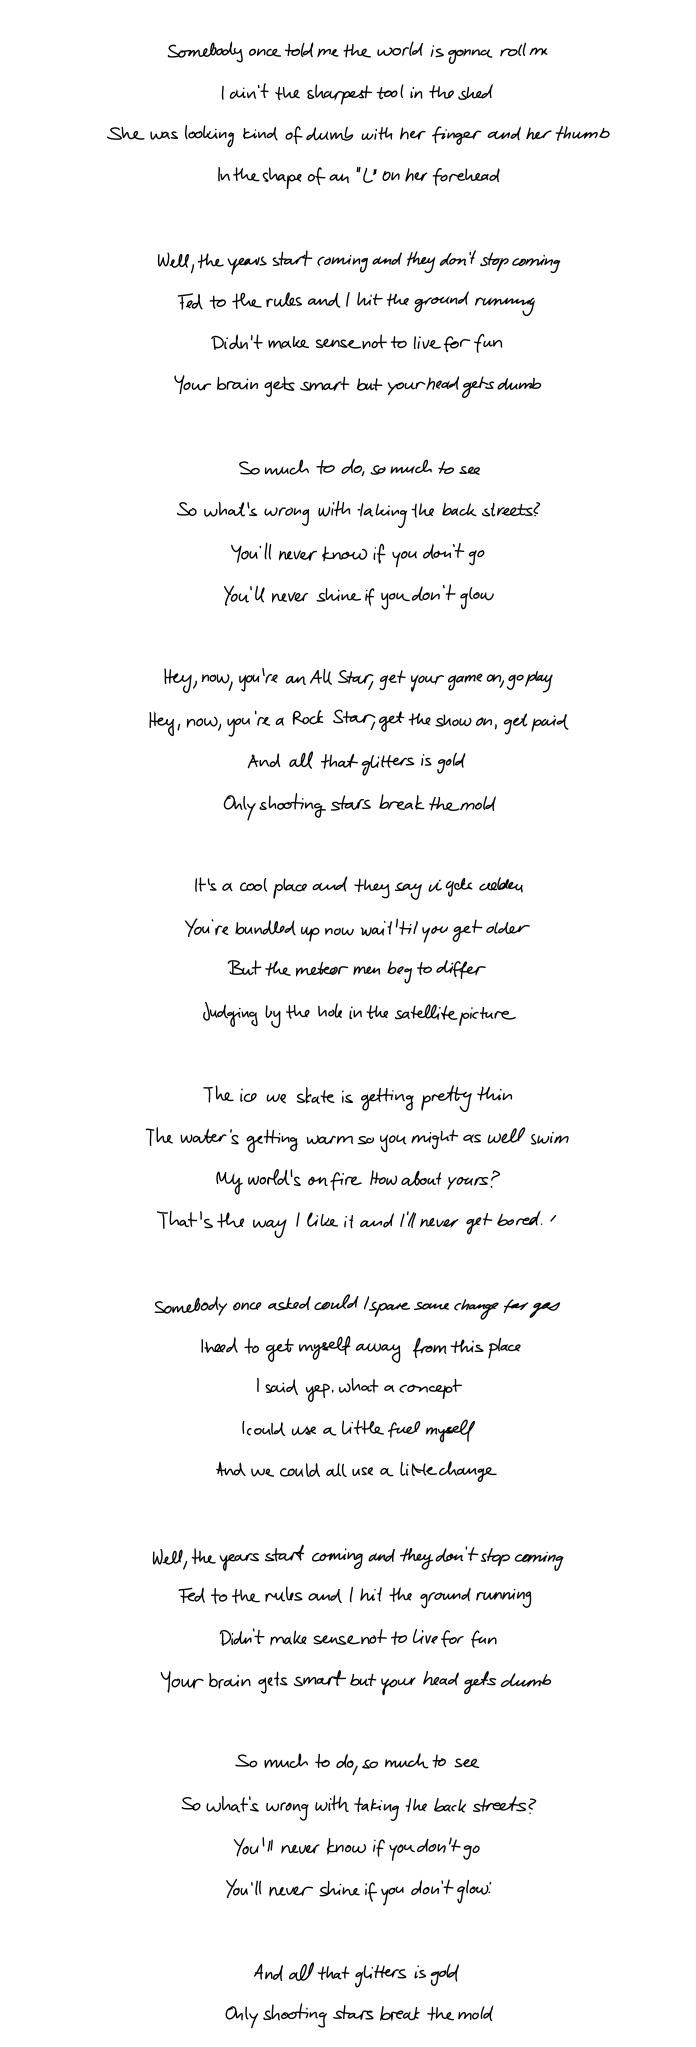

In [5]:
lines = lyrics.all_star.split("\n")
biases = [.75 for i in lines]
styles = [12 for i in lines]
strokes = sample(nn, lines, biases=biases, styles=styles)
draw(strokes, lines, filename='img/{}.svg'.format('all_star'))

## demo number 2 - fixed bias, varying style

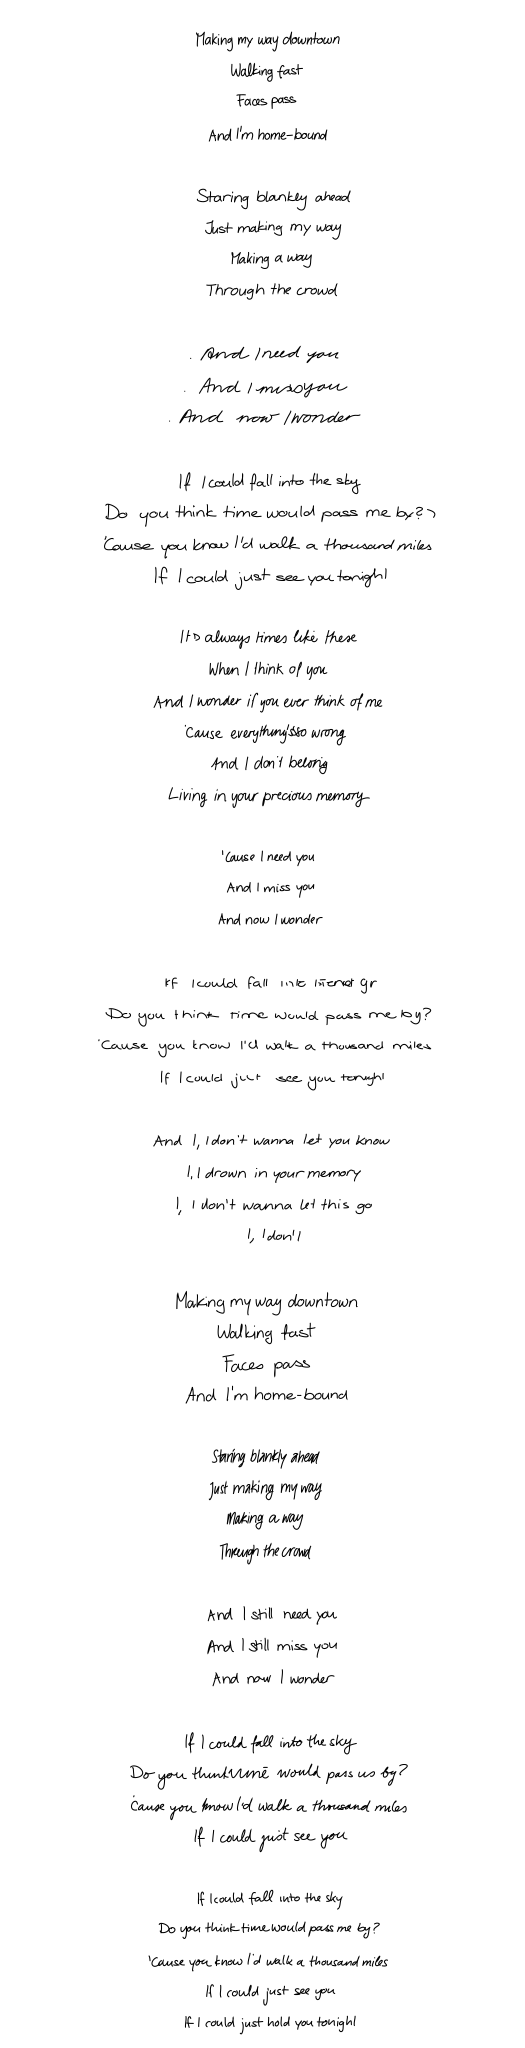

In [6]:
lines = lyrics.downtown.split("\n")
biases = [.75 for i in lines]
styles = np.cumsum(np.array([len(i) for i in lines]) == 0).astype(int)
strokes = sample(nn, lines, biases=biases, styles=styles)
draw(strokes, lines, filename='img/{}.svg'.format('downtown'))

## demo number 3 - varying bias, fixed style

In [7]:
lines = lyrics.give_up.split("\n")
verse_nums = np.cumsum(np.array([len(i) for i in lines]) == 0)
biases = [.2*(max(verse_nums) - i) for i in verse_nums]
styles = [7 for i in lines]
strokes = sample(nn, lines, biases=biases, styles=styles)
draw(strokes, lines, filename='img/{}.svg'.format('give_up'))